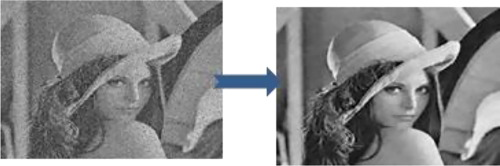

#Noise Reduction


# 1. Import

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.utils import save_image

import matplotlib
import matplotlib.pyplot as plt
import PIL

In [37]:
print(f'torch version       : {torch.__version__}')
print(f'torchvision version : {torchvision.__version__}')
print(f'matplotlib version  : {matplotlib.__version__}')
print(f'PIL version         : {PIL.__version__}')

torch version       : 2.0.1+cu118
torchvision version : 0.15.2+cu118
matplotlib version  : 3.7.1
PIL version         : 9.4.0


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2. MNIST Dataset

In [39]:
train_dataset = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

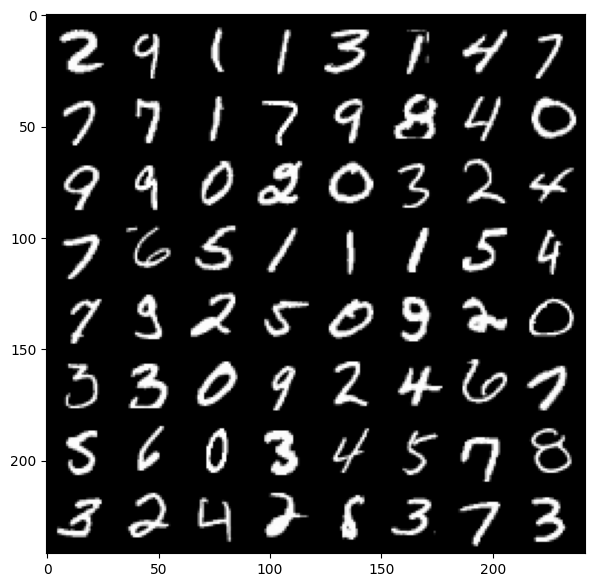

In [40]:
batch = next(iter(train_loader))
images, labels = batch

plt.figure(figsize=(7,7))
grid = torchvision.utils.make_grid(tensor=images, nrow=8)
plt.imshow(grid.permute(1,2,0))

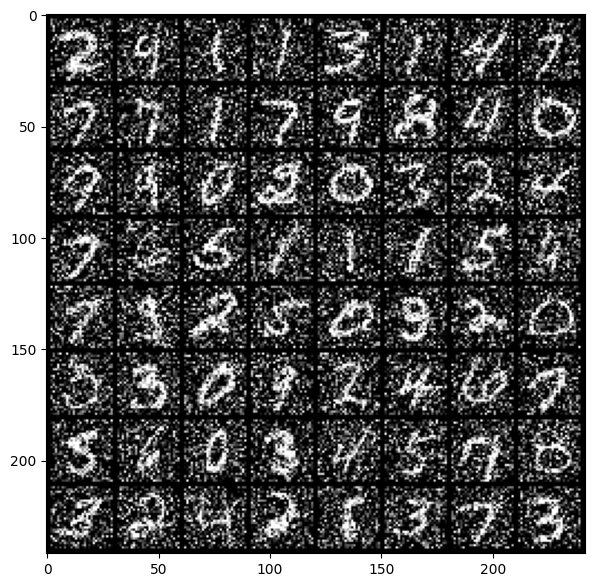

In [41]:
noisy_images = images + torch.randn(images.shape) * 0.5
plt.figure(figsize=(7, 7))
grid = torchvision.utils.make_grid(tensor=noisy_images, nrow=8)
plt.imshow(grid.permute(1,2,0))

# 2. Model

In [42]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [43]:
def train(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            noisy_img = img + torch.randn(img.shape).to(device) * 0.5
            noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
            optimizer.zero_grad()
            output = model(noisy_img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.6f}")

In [44]:
def test(model, test_loader, device):
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.to(device)
            img = img.view(1, 1, 28, 28)
            noisy_img = img + torch.randn(img.shape).to(device) * 0.5
            noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
            output = model(noisy_img.to(device))
            save_image(img.view(1, 1, 28, 28), 'original.png')
            save_image(noisy_img.view(1, 1, 28, 28), 'noisy.png')
            save_image(output.view(1, 1, 28, 28), 'denoised.png')
            break

# 5. Train

In [45]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

In [46]:
train(model, train_loader, criterion, optimizer, epochs)

Epoch 1, Loss: 0.048541
Epoch 2, Loss: 0.017112
Epoch 3, Loss: 0.013828
Epoch 4, Loss: 0.012747
Epoch 5, Loss: 0.012143


# 6. Result

In [47]:
test(model, test_loader, device)

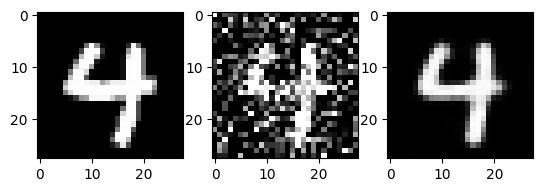

In [48]:
original = PIL.Image.open('original.png')
noisy = PIL.Image.open('noisy.png')
denoised = PIL.Image.open('denoised.png')

fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0].imshow(original)
axes[1].imshow(noisy)
axes[2].imshow(denoised)

plt.show()